# Create CNN models

In [1]:
import tensorflow as tf

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [1]:
# imports
import numpy as np
import tensorflow as tf
import keras
import os, shutil

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


TensorFlow version: 2.10.0
Keras version: 2.10.0


In [2]:
# load dataset csv
df_eye = pd.read_csv('./data/df_eye.csv')

### Directories

In [4]:
# The path to store trained models
models_dir = r'./models/' 
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where is original dataset
original_dataset_dir = r'./data/preprocessed_images/'

# The directory where we will store our smaller dataset
base_dir = r'./dataset256/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

split_dir = base_dir + r'split256/'
if not os.path.exists(split_dir):
    os.mkdir(split_dir)

# Prepare directories for the class separation
normal_dir = os.path.join(split_dir, r'normal256')
if not os.path.exists(normal_dir):
    os.mkdir(normal_dir)
    
diabetes_dir = os.path.join(split_dir, r'diabetes256')
if not os.path.exists(diabetes_dir):
    os.mkdir(diabetes_dir)
    
glaucoma_dir = os.path.join(split_dir, r'glaucoma256')
if not os.path.exists(glaucoma_dir):
    os.mkdir(glaucoma_dir)
    
cataract_dir = os.path.join(split_dir, r'cataract256')
if not os.path.exists(cataract_dir):
    os.mkdir(cataract_dir)
    
age_macular_dir = os.path.join(split_dir, r'age_macular256')
if not os.path.exists(age_macular_dir):
    os.mkdir(age_macular_dir)
    
hypertension_dir = os.path.join(split_dir, r'hypertension256')
if not os.path.exists(hypertension_dir):
    os.mkdir(hypertension_dir)
    
myopia_dir = os.path.join(split_dir, r'myopia256')
if not os.path.exists(myopia_dir):
    os.mkdir(myopia_dir)

other_dir = os.path.join(split_dir, r'other256')
if not os.path.exists(other_dir):
    os.mkdir(other_dir)

### Each eye disease data class

In [10]:
class DataClass():
    def __init__(self, _name: str, _filenames: [str], _target: [int], _abbreviation: str, _directory: str):
        self.name = _name
        self.filenames = _filenames
        self.target = _target
        self.abbreviation  = _abbreviation
        self.directory = _directory
        
    def __str__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"
    
    def __repr__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"

# THAT'S WRONG! THIS LABEL IS ATTACHED TO EACH PATIENT NOT TO EACH EYE!
# UPDATE: it's correct, labels are correctly assigned even though each label columns are 
# attached to each patient
normal_filenames = df_eye[df_eye.labels == "['N']"].filename.values
diabetes_filenames = df_eye[df_eye.labels == "['D']"].filename.values
glaucoma_filenames = df_eye[df_eye.labels == "['G']"].filename.values
cataract_filenames = df_eye[df_eye.labels == "['C']"].filename.values
age_macular_filenames = df_eye[df_eye.labels == "['A']"].filename.values
hypertension_filenames = df_eye[df_eye.labels == "['H']"].filename.values
myopia_filenames = df_eye[df_eye.labels == "['M']"].filename.values
other_filenames = df_eye[df_eye.labels == "['O']"].filename.values

normal_class = DataClass('normal', normal_filenames, [1, 0, 0, 0, 0, 0, 0, 0], 'N', normal_dir)
diabetes_class = DataClass('diabetes', diabetes_filenames, [0, 1, 0, 0, 0, 0, 0, 0], 'D', diabetes_dir)
glaucoma_class = DataClass('glaucoma', glaucoma_filenames, [0, 0, 1, 0, 0, 0, 0, 0], 'G', glaucoma_dir)
cataract_class = DataClass('cataract', cataract_filenames, [0, 0, 0, 1, 0, 0, 0, 0], 'C', cataract_dir)
age_macular_class = DataClass('age_macular', age_macular_filenames, [0, 0, 0, 0, 1, 0, 0, 0], 'A', age_macular_dir)
hypertension_class = DataClass('hypertension', hypertension_filenames, [0, 0, 0, 0, 0, 1, 0, 0], 'H', hypertension_dir)
myopia_class = DataClass('myopia', myopia_filenames, [0, 0, 0, 0, 0, 0, 1, 0], 'M', myopia_dir)
other_class = DataClass('other', other_filenames, [0, 0, 0, 0, 0, 0, 0, 1], 'O', other_dir)

data_classes = [
    normal_class, 
    diabetes_class, 
    glaucoma_class, 
    cataract_class, 
    age_macular_class, 
    hypertension_class, 
    myopia_class, 
    other_class
]

In [6]:
normal_class.directory

'./dataset256/split256/normal256'

### Quick look at the data

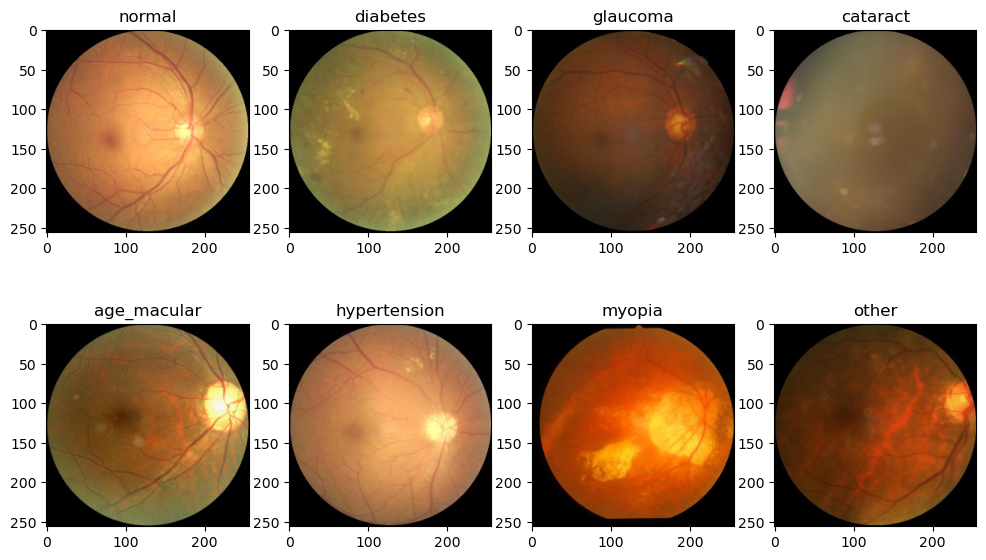

In [7]:
fig, axs = plt.subplots(2,4, figsize=(12,7))
for i, data_class in enumerate(data_classes):
    image = plt.imread(f"{data_class.directory}/{data_class.filenames[64]}")
    axs[0 if i < 4 else 1, i % 4].imshow(image)
    axs[0 if i < 4 else 1, i % 4].set_title(data_class.name)

## Split data into `train`, `validate` and `test` set

In [6]:
train_dir = r'./dataset256/train/'
validation_dir = r'./dataset256/validation/'
test_dir = r'./dataset256/test/'

img_rows = 256
img_cols = 256
num_class = 8

In [9]:
from sklearn.model_selection import train_test_split

# prepare data sets
def prepare_data(data_class: DataClass, train_size: float, validation_test_ratio:float):
    # validation_test_ratio -> how much of `data - train_data` goes to validation
    # 
    # for instance, we've given: train_size, validation_test_ratio
    # then
    # train_size = data * train_size
    # validation_size = ( 1 - train_size) * validation_test_ratio
    # test_size = ( 1 - train_size) * (1 - validation_test_ratio)
    # ---
    
    # check if directories are created
    class_train_dir = os.path.join(train_dir, data_class.name)
    if not os.path.exists(class_train_dir):
        os.makedirs(class_train_dir)

    class_validation_dir = os.path.join(validation_dir, data_class.name)
    if not os.path.exists(class_validation_dir):
        os.makedirs(class_validation_dir)

    class_test_dir = os.path.join(test_dir, data_class.name)
    if not os.path.exists(class_test_dir):
        os.makedirs(class_test_dir)
    
    # split class filenames into three separate bins in line with split ratio
    train_filenames, test_valid_filenames = train_test_split(data_class.filenames, test_size=1.0-train_size)
    # divide images into test and validation sets
    validation_filenames, test_filenames = train_test_split(test_valid_filenames, test_size=1-validation_test_ratio)
    
    for key, destination_dir, filenames in [('train', class_train_dir, train_filenames), ('test', class_test_dir, test_filenames), ('validation', class_validation_dir, validation_filenames)]:
        if os.path.exists(destination_dir) and not os.path.isfile(destination_dir):
            # Checking if the directory is empty or not
            if not os.listdir(destination_dir):
                # copy files
                for filename in filenames:
                    src = os.path.join(split_dir + f"{data_class.name}256/{filename}")
                    dst = os.path.join(destination_dir, filename)
                    shutil.copyfile(src, dst)
        # validate if number of each class in dataframe and destination directory is the same
        assert(len(filenames) == len(os.listdir(destination_dir)))

### Class `other` is ommitted since it doesn't stands for any particular disease

In [56]:
for data_class in data_classes[:-1]:
    prepare_data(data_class, train_size=0.7, validation_test_ratio=0.9)

## Distribution

In [62]:
classes = []
num_of_imgs = []

# remove 'other' class
for data_class in data_classes[:-1]:
    classes.append(data_class.name)
    num_of_imgs.append(len(data_class.filenames))

print(classes)
print(num_of_imgs)

['normal', 'diabetes', 'glaucoma', 'cataract', 'age_macular', 'hypertension', 'myopia']
[2752, 1584, 277, 269, 266, 128, 226]


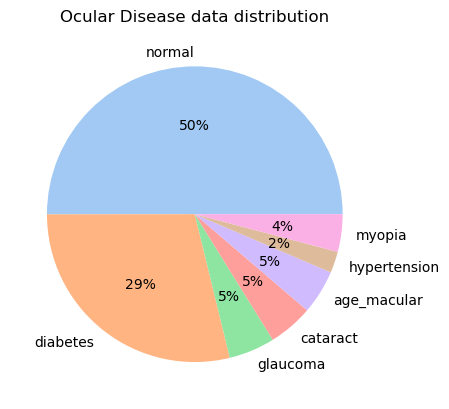

In [63]:
colors = sns.color_palette('pastel')[0:len(classes)]

plt.pie(num_of_imgs, labels = classes, colors = colors, autopct='%.0f%%')
plt.title('Ocular Disease data distribution')
plt.show()

## Create image generators

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images are already resized 
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=15,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    # This is the target directory
    test_dir,
    # All images are already resized 
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=15,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    # This is the target directory
    validation_dir,
    # All images are already resized 
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=15,
    class_mode='categorical')

Found 3858 images belonging to 7 classes.
Found 168 images belonging to 7 classes.
Found 1486 images belonging to 7 classes.


### Model BUILDER 
Method used in order not to copy the model each time, just modify this method call `build_model` and then `model.summary()` to show your model structure. If model works well copy the code into separate cell to save activations etc.

In [99]:
def build_model():
    model = models.Sequential()
    # add layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    # num_class -1 because 'other' is dropped
    model.add(layers.Dense(num_class-1, activation='softmax'))
    
    return model

## Create model

In [95]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
# num_class -1 because 'other' is dropped
model1.add(layers.Dense(num_class-1, activation='softmax'))

In [96]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 128)     

In [97]:
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=[tf.keras.metrics.Recall()])

In [98]:
history1 = model1.fit(
      train_generator,
      steps_per_epoch=89,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=19)

Epoch 1/50
89/89 [==============================] - 8s 73ms/step - loss: 1.4070 - recall_2: 0.1739 - val_loss: 1.4738 - val_recall_2: 0.0982
Epoch 2/50
89/89 [==============================] - 6s 64ms/step - loss: 1.4064 - recall_2: 0.1920 - val_loss: 1.2475 - val_recall_2: 0.3614
Epoch 3/50
89/89 [==============================] - 6s 65ms/step - loss: 1.3367 - recall_2: 0.1978 - val_loss: 1.4423 - val_recall_2: 0.1930
Epoch 4/50
89/89 [==============================] - 6s 66ms/step - loss: 1.3790 - recall_2: 0.2139 - val_loss: 1.3101 - val_recall_2: 0.1053
Epoch 5/50
89/89 [==============================] - 6s 65ms/step - loss: 1.3301 - recall_2: 0.2479 - val_loss: 1.3405 - val_recall_2: 0.0947
Epoch 6/50
89/89 [==============================] - 6s 68ms/step - loss: 1.3097 - recall_2: 0.2816 - val_loss: 1.2562 - val_recall_2: 0.0246
Epoch 7/50
89/89 [==============================] - 6s 65ms/step - loss: 1.3590 - recall_2: 0.2180 - val_loss: 1.2525 - val_recall_2: 0.2596
Epoch 8/50
89

In [77]:
result1 = model1.evaluate(test_generator)
dict(zip(model1.metrics_names, result1))

34/34 [==============================] - 1s 32ms/step - loss: 1.1999 - recall_1: 0.3988


{'loss': 1.199907898902893, 'recall_1': 0.3988095223903656}

### Confusion matrix 

In [81]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
Y_pred = model1.predict(test_generator, steps=test_steps_per_epoch)
y_pred = np.argmax(Y_pred, axis=1)

34/34 [==============================] - 1s 17ms/step


In [ ]:
conf_matrix_result = confusion_matrix(test_generator.classes, y_pred)
clssification_report_result = classification_report(test_generator.classes, y_pred)

print('Confusion Matrix')
print(conf_matrix_result)

print('Classification Report')
print(clssification_report_result)

In [ ]:
# Keras sorts the labels (names of folders in the train directory) by alphabetical order
classes = sorted([data_class.name for data_class in data_classes])
classes.remove('other')

In [19]:
# create method for confusion matrix plotting
def plot_conf_matrix(model, test_generator, classes):
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
    Y_pred = model.predict(test_generator, steps=test_steps_per_epoch)
    y_pred = np.argmax(Y_pred, axis=1)
    
    conf_matrix_result = confusion_matrix(test_generator.classes, y_pred)
    clssification_report_result = classification_report(test_generator.classes, y_pred)
    # print('Confusion Matrix')
    # print(conf_matrix_result)
    # print('Classification Report')
    # print(clssification_report_result)

    # Keras sorts the labels (names of folders in the train directory) by alphabetical order
    alphabetical_classes = sorted(classes)
    df_cm = pd.DataFrame(conf_matrix_result, index = alphabetical_classes,
                  columns = alphabetical_classes)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt="")

12/12 [==============================] - 1s 50ms/step


C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


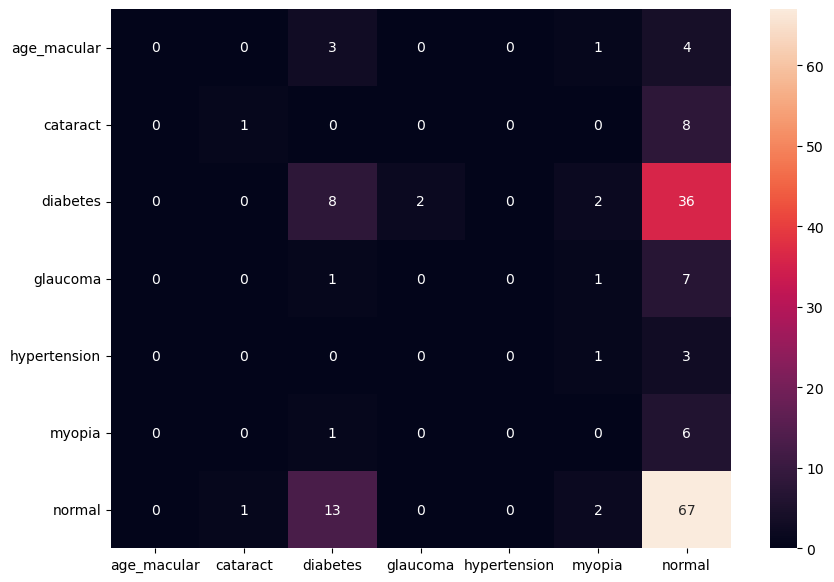

In [102]:
plot_conf_matrix(model1, test_generator, classes)

## Add data augmentation

In [33]:
# with augmentation
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=30,
    # shear_range=0.2,
    # zoom_range=0.05
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1)
)

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=32,
    shuffle=True,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    # This is the target directory
    test_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=32,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    # This is the target directory
    validation_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=32,
    class_mode='categorical')

Found 3858 images belonging to 7 classes.
Found 168 images belonging to 7 classes.
Found 1486 images belonging to 7 classes.


### Data augmentation visualisation

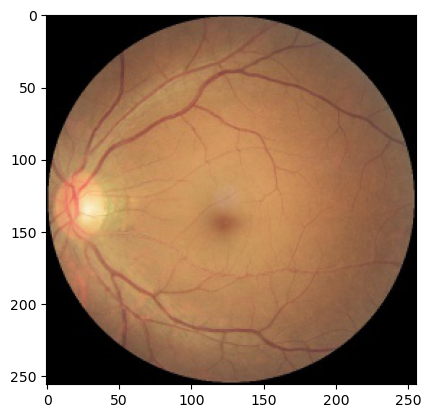

In [49]:
import cv2

img_path = './dataset256/train/normal/1011_left.jpg'
img = tf.keras.preprocessing.image.load_img(img_path)
plt.imshow(img)

In [28]:
image = tf.keras.preprocessing.image.load_img(img_path)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
# predictions = model.predict(input_arr)

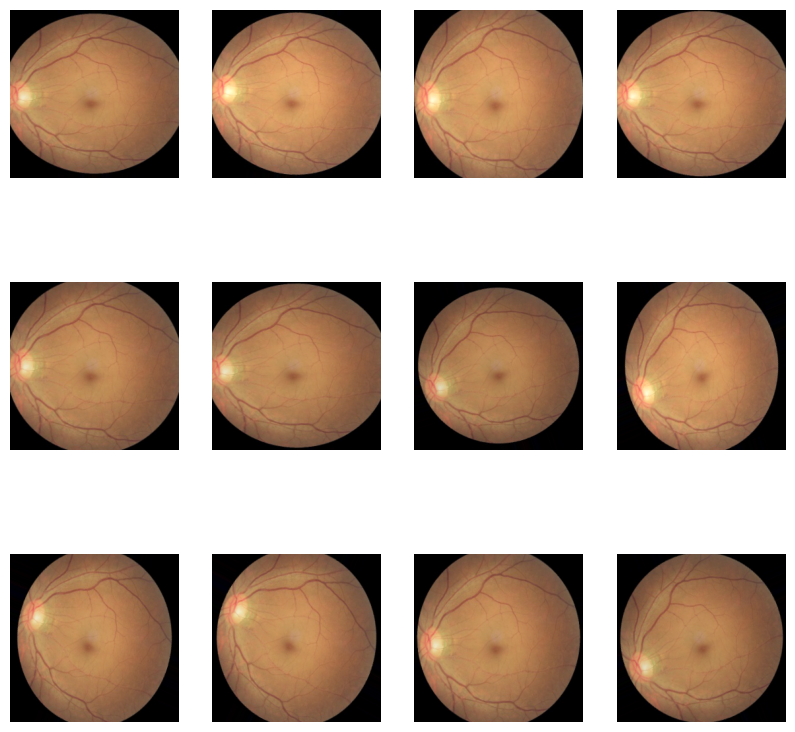

In [47]:
# ImageDataGenerator shifting
datagen_vis = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.1,
    brightness_range=(0.9, 1.1)
)

# iterator
aug_iter = datagen_vis.flow(np.array(input_arr))

# generate samples and plot
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10,10))
# generate batch of images
for i in range(12):

	# convert to unsigned integers
	image = next(aug_iter)[0].astype('uint8')
 
	# plot image
	ax[i//4, i%4].imshow(image)
	ax[i//4, i%4].axis('off')

## Create model

In [20]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
# num_class -1 because 'other' is dropped
model2.add(layers.Dense(num_class-1, activation='softmax'))

In [21]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 128)     

In [22]:
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=[tf.keras.metrics.Recall()])

In [23]:
history2 = model2.fit(
      train_generator,
      steps_per_epoch=89,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=19)

Epoch 1/30
89/89 [==============================] - 8s 69ms/step - loss: 1.4457 - recall_1: 0.1416 - val_loss: 1.4089 - val_recall_1: 0.0386
Epoch 2/30
89/89 [==============================] - 6s 65ms/step - loss: 1.3905 - recall_1: 0.1963 - val_loss: 1.3830 - val_recall_1: 0.0105
Epoch 3/30
89/89 [==============================] - 6s 66ms/step - loss: 1.3893 - recall_1: 0.1618 - val_loss: 1.3059 - val_recall_1: 0.0737
Epoch 4/30
89/89 [==============================] - 6s 66ms/step - loss: 1.3248 - recall_1: 0.2689 - val_loss: 1.3449 - val_recall_1: 0.2702
Epoch 5/30
89/89 [==============================] - 6s 66ms/step - loss: 1.3094 - recall_1: 0.2464 - val_loss: 1.3285 - val_recall_1: 0.2211
Epoch 6/30
89/89 [==============================] - 6s 70ms/step - loss: 1.3150 - recall_1: 0.2638 - val_loss: 1.3673 - val_recall_1: 0.1544
Epoch 7/30
89/89 [==============================] - 6s 65ms/step - loss: 1.3009 - recall_1: 0.2479 - val_loss: 1.3192 - val_recall_1: 0.2456
Epoch 8/30
89

In [24]:
result2 = model2.evaluate(test_generator)
dict(zip(model2.metrics_names, result2))

12/12 [==============================] - 0s 26ms/step - loss: 1.1619 - recall_1: 0.3929


{'loss': 1.161933183670044, 'recall_1': 0.3928571343421936}

### Confusion matrix 

In [109]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
Y_pred = model1.predict(test_generator, steps=test_steps_per_epoch)
y_pred = np.argmax(Y_pred, axis=1)

12/12 [==============================] - 0s 28ms/step


In [110]:
conf_matrix_result = confusion_matrix(test_generator.classes, y_pred)
clssification_report_result = classification_report(test_generator.classes, y_pred)

print('Confusion Matrix')
print(conf_matrix_result)

print('Classification Report')
print(clssification_report_result)

Confusion Matrix
[[ 0  0  4  0  0  0  4]
 [ 0  0  1  0  0  2  6]
 [ 0  0 13  0  0  3 32]
 [ 0  0  2  0  0  0  7]
 [ 0  0  2  0  0  0  2]
 [ 0  0  1  0  0  0  6]
 [ 0  1 17  0  0  0 65]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         9
           2       0.33      0.27      0.30        48
           3       0.00      0.00      0.00         9
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         7
           6       0.53      0.78      0.63        83

    accuracy                           0.46       168
   macro avg       0.12      0.15      0.13       168
weighted avg       0.36      0.46      0.40       168



C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Keras sorts the labels (names of folders in the train directory) by alphabetical order
classes = sorted([data_class.name for data_class in data_classes])
classes.remove('other')

In [1]:
# create method for confusion matrix plotting
def plot_conf_matrix(model, test_generator, classes):
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
    Y_pred = model.predict(test_generator, steps=test_steps_per_epoch)
    y_pred = np.argmax(Y_pred, axis=1)
    
    conf_matrix_result = confusion_matrix(test_generator.classes, y_pred)
    clssification_report_result = classification_report(test_generator.classes, y_pred)
    # print('Confusion Matrix')
    # print(conf_matrix_result)
    # print('Classification Report')
    # print(clssification_report_result)

    # Keras sorts the labels (names of folders in the train directory) by alphabetical order
    alphabetical_classes = sorted(classes)
    df_cm = pd.DataFrame(conf_matrix_result, index = alphabetical_classes,
                  columns = alphabetical_classes)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt="")

12/12 [==============================] - 0s 26ms/step


C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


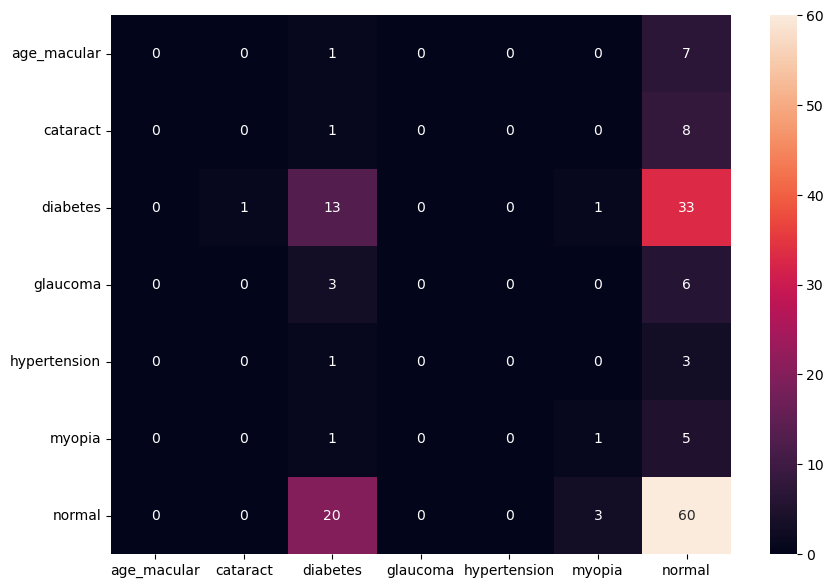

In [118]:
plot_conf_matrix(model1, test_generator, classes)

12/12 [==============================] - 1s 48ms/step


C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


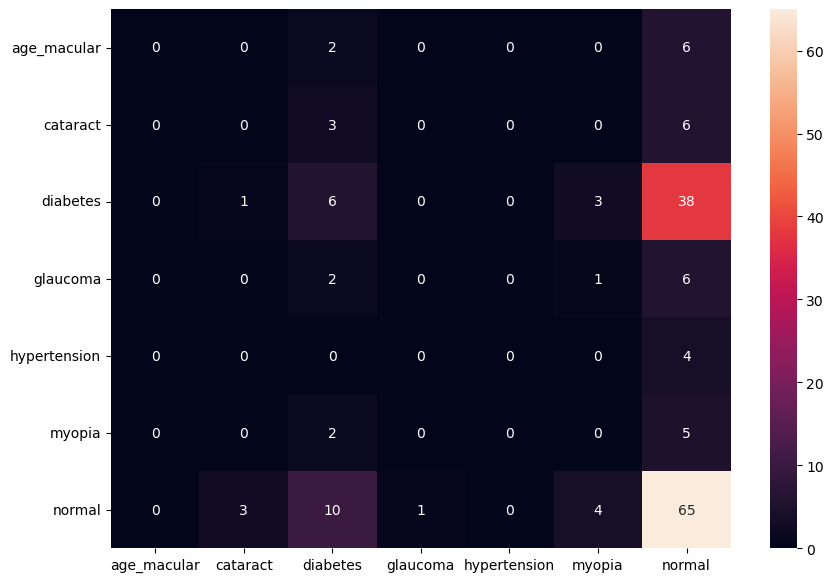

In [26]:
plot_conf_matrix(model2, test_generator, classes)

In [133]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html
    
def PlotMetricComparison(metric, val_metric, metric_name, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(metric))
    plt.plot(epochs, metric, 'bo', label=f'Training metric - {metric_name}, {lab}')
    plt.plot(epochs, val_metric, 'b', label='Validation metric - ' + lab)
    plt.title('Comparison of Training and Validation metric')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

In [123]:
history1.history.keys()

dict_keys(['loss', 'recall_3', 'val_loss', 'val_recall_3'])

<Figure size 640x480 with 0 Axes>

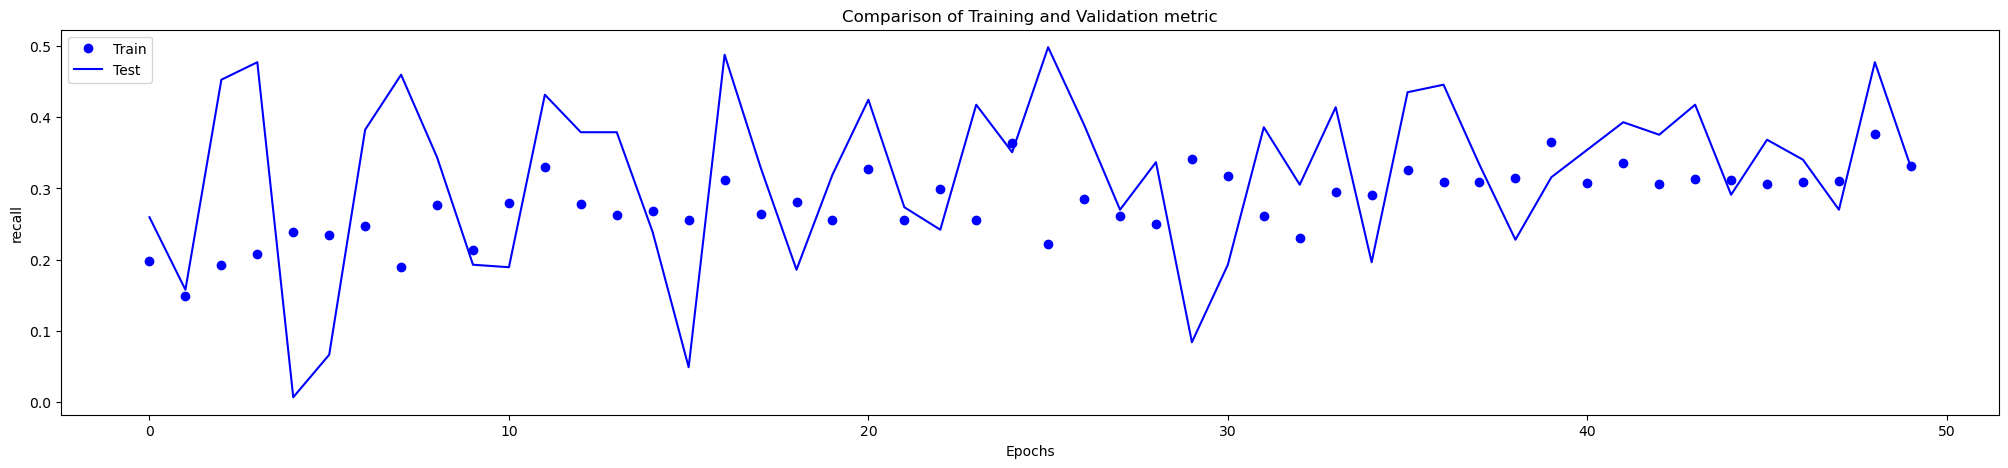

<Figure size 640x480 with 0 Axes>

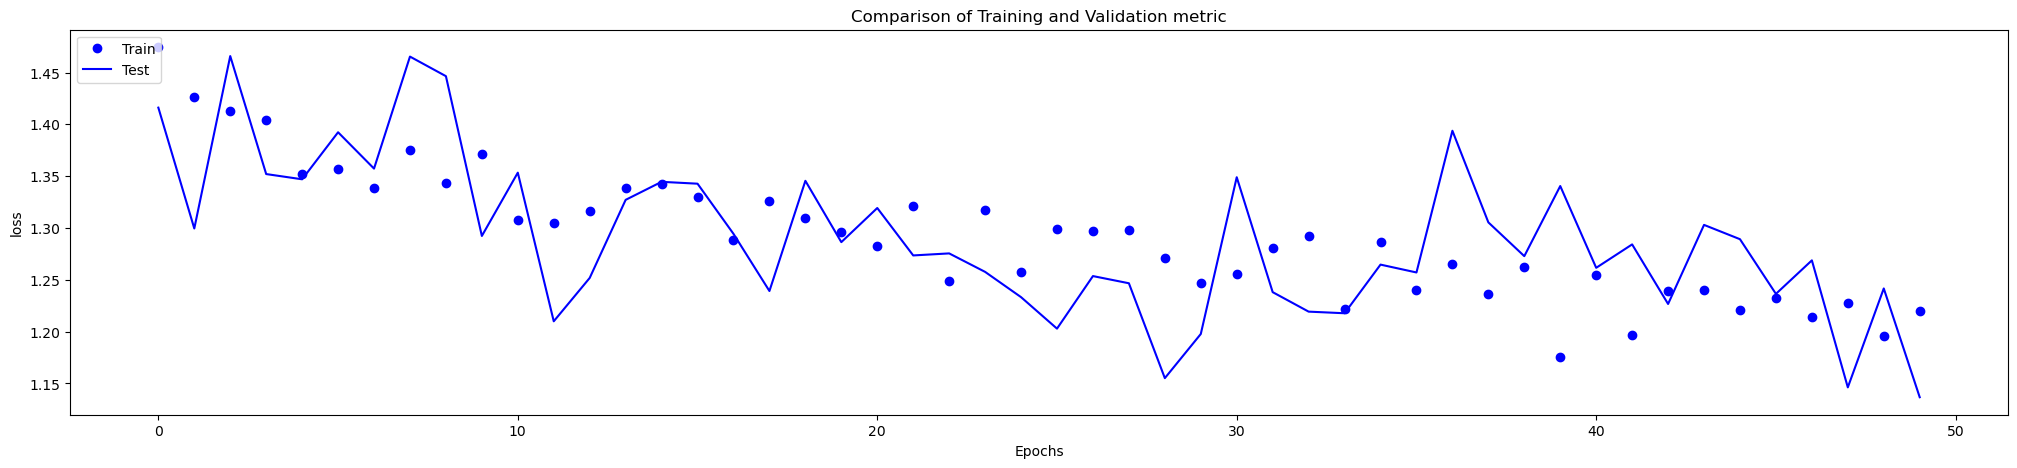

In [135]:
recall1 = history1.history['recall_3']
val_recall1 = history1.history['val_recall_3']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

# models_acc.append(acc1)
# models_val_acc.append(val_acc1)
# models_loss.append(loss1)
# models_val_loss.append(val_loss1)

PlotMetricComparison(recall1, val_recall1, metric_name='recall', lab = 'Model 1')
PlotMetricComparison(loss1, val_loss1, metric_name='loss', lab = 'Model 1')

`Cats and dogs` model

In [34]:
model8 = models.Sequential()
model8.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model8.add(layers.MaxPooling2D((2, 2), padding='same'))
model8.add(layers.Conv2D(128, (3, 3), activation='relu'))
model8.add(layers.Conv2D(256, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2), padding='same'))
model8.add(layers.Conv2D(512, (3, 3), activation='relu'))
model8.add(layers.Conv2D(256, (3, 3), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2), padding='same'))
model8.add(layers.Flatten())
model8.add(layers.Dropout(0.5))
model8.add(layers.Dense(256, activation='relu'))
model8.add(layers.Dense(7, activation='softmax'))

model8.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [35]:
history8 = model8.fit(
      train_generator,
      steps_per_epoch=30,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=10)

Epoch 1/20
30/30 [==============================] - 17s 470ms/step - loss: 1.5802 - recall_3: 0.1167 - recall_4: 0.1167 - val_loss: 1.3895 - val_recall_3: 0.3688 - val_recall_4: 0.3688
Epoch 2/20
30/30 [==============================] - 15s 483ms/step - loss: 1.3701 - recall_3: 0.2229 - recall_4: 0.2229 - val_loss: 1.3619 - val_recall_3: 0.4844 - val_recall_4: 0.4844
Epoch 3/20
30/30 [==============================] - 15s 483ms/step - loss: 1.4303 - recall_3: 0.1896 - recall_4: 0.1896 - val_loss: 1.3739 - val_recall_3: 0.0469 - val_recall_4: 0.0469
Epoch 4/20
30/30 [==============================] - 17s 557ms/step - loss: 1.3353 - recall_3: 0.3097 - recall_4: 0.3097 - val_loss: 1.4380 - val_recall_3: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 5/20
30/30 [==============================] - 14s 476ms/step - loss: 1.3576 - recall_3: 0.2516 - recall_4: 0.2516 - val_loss: 1.3946 - val_recall_3: 0.5156 - val_recall_4: 0.5156
Epoch 6/20
30/30 [==============================] - 15s 485ms/step 

12/12 [==============================] - 0s 34ms/step


C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


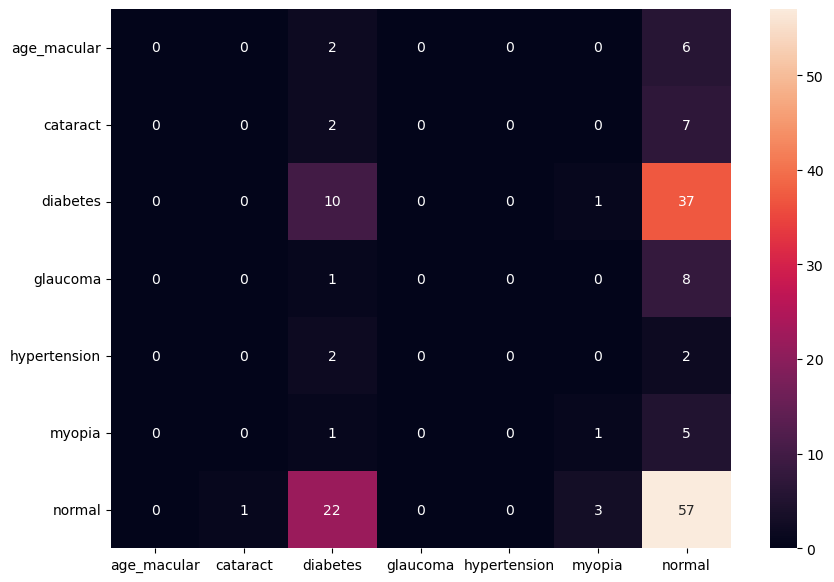

In [143]:
plot_conf_matrix(model8, test_generator, classes)

In [ ]:
plot_conf_matrix(model8, test_generator, classes)

100/100 [==============================] - 3s 33ms/step


C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


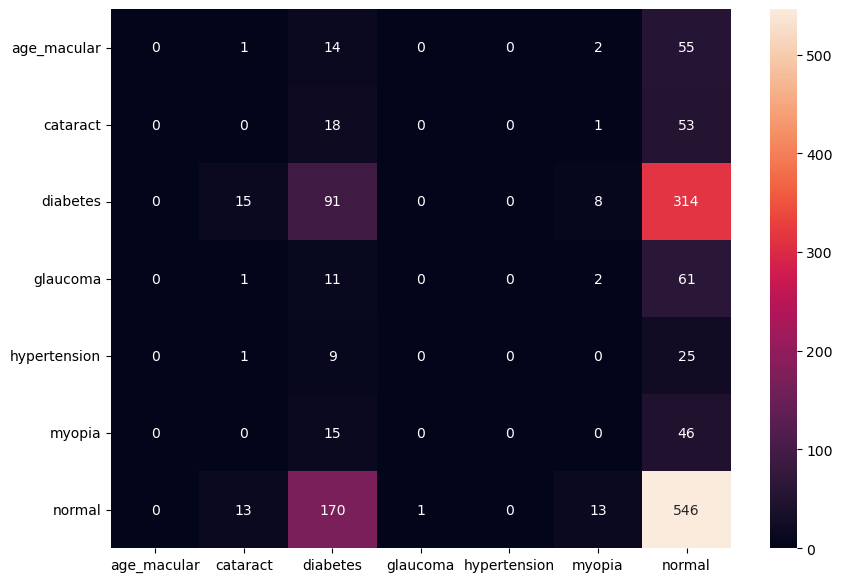

In [144]:
plot_conf_matrix(model8, validation_generator, classes)

6/6 [==============================] - 3s 485ms/step


C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


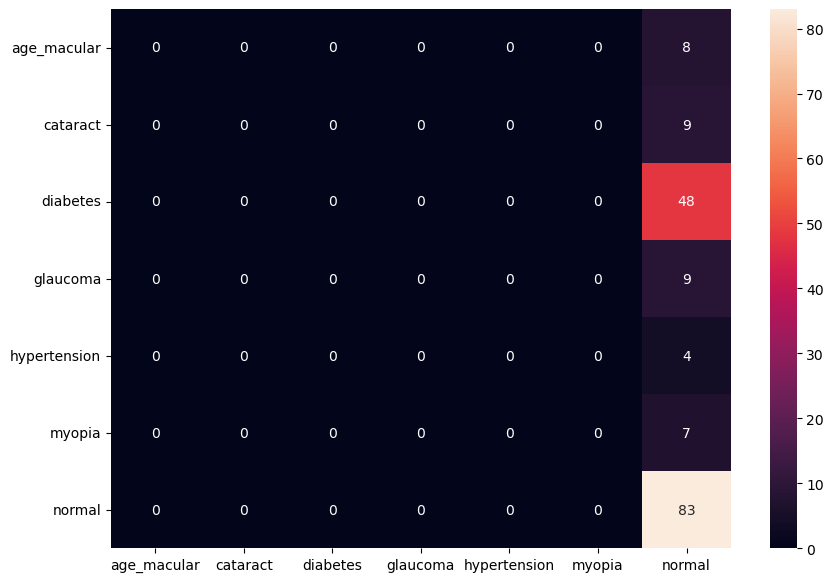

In [38]:
plot_conf_matrix(model8, test_generator, classes)

In [ ]:
plot_conf_matrix(model8, validation_generator, classes)

Unfortunately, classification of such similar images came out as a really hard task for simple CNNs. There are a couple of articles analysing this particular dataset where the final accuracy oscillates around 80% with the use of transfer learning (VGG-19, EfficientNetB6, ResNet).